<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Noemi Fazzini, Antonio Vecoli (MEEO)

# Metop-B IASI Total Column Carbon Monoxide Carbon Monoxide, Formic Acid - Level 2 and Metop-B GOME-2 L3 Absorbing Areosol Index product

<div class="alert alert-block alert-info">
<b>How to access the data</b>
</div>

* IASI Level 2 are disseminated in the `netCDF` format and can be downloaded via the [IASI catalog](https://iasi.aeris-data.fr/catalog/)
* GOME-2 AAI Level 3 data are available for download via <a href='http://www.temis.nl/airpollution/absaai/' target='_blank'>TEMIS</a>, a web-based service for atmospheric satellite data products maintained by KNMI. TEMIS provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C. You can go to the <a href='https://www.temis.nl/airpollution/absaai/#GOME2_AAI' target='_blank'>download page</a>, select under `GOME-2 / MetOp-A AAI daily gridded` the year `2023` and then click on `21-22-23 August 2023`. The download of the selected NetCDF file will start.

This module has the following outline:
* [1 - Load and preprocess Metop-A/B IASI Level 2 CO data](#load_co)
* [5 - Visualize Metop-A/B IASI Level 2 CO data](#visualize_co)
* [1 - Load and preprocess Metop-A/B IASI Level 2 HCOOH data](#load_hcooh)
* [5 - Visualize Metop-A/B IASI Level 2 HCOOH data](#visualize_hcooh)
* [5 - Load and Visualize Metop-A/B GOME-2 B Level 3 AAI data](#aai)

#### Load required libraries and define variables and coordinates

In [1]:
import xarray as xr
import pandas as pd
from datetime import datetime
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import HTML, display

In [2]:
%run ../helper_functions.ipynb

In [2]:
latmin = 30
latmax = 50
lonmin = 15
lonmax = 40

start_day = '2023-08-21'

## Carbon Monoxide - CO

The Infrared Atmospheric Sounding Interferometer (IASI) is an instrument onboard the Metop-B/C satellites. It was also previously aboard Metop-A. 

It provides information on the vertical structure of temperature and humidity as well as main atmospheric species, such as Carbon Monoxide and Formic Acid.

### <a id='load_co'></a>Load and preprocess Metop-A/B IASI Level 2 CO data

The `preprocess_co` function processes carbon monoxide (CO) data from an `xarray.Dataset`:
1. `fill_and_align`: function to pad or truncate the dataset along a specified dimension to match target_size. This is done to open all the intersted file as a single xarray.Dataset.
2. `process_time_range`: function to extract and mask CO and quality flag data and align the data size and add a time_of_day dimension.
3. Filter Dataset based on latitude and longitude
4. Create Time Masks: Generates masks for day and night based on time of day
5. Process CO data separately for day and night using the `process_time_range` function and then combine data along a new time_of_day dimension.

In [3]:
def preprocess_co(ds):

    target_size = 406062  # Maximum size found across datasets for alignment
    
    def fill_and_align(da, target_size, dim='ground_pixel'):
        """
        Fill missing values and align the specified dimension to the target size.
        """
        current_size = da.sizes.get(dim, None)
        if current_size is not None:
            if current_size < target_size:
                # Pad with NaNs
                padding = target_size - current_size
                da = da.pad({dim: (0, padding)}, constant_values=np.nan)
            elif current_size > target_size:
                # Truncate
                da = da.isel({dim: slice(0, target_size)})
        else:
            # If dimension is missing, create a new dimension with NaNs
            da = da.expand_dims({dim: target_size})
            da = da.pad({dim: (0, target_size)}, constant_values=np.nan)
        
        return da
    
    def process_time_range(data_array, mask, time_of_day):

        # Select data variable
        co = data_array.isel(time=mask)['CO_total_column']

        # Load the `Total Column Carbon Monoxide` information into a `xarray.DataArray`.
        co_da = generate_xr_from_1d_vec(file=data_array.isel(time=mask),
                                        lat_path='latitude', 
                                        lon_path='longitude',
                                        variable=co, 
                                        parameter_name=co.standard_name, 
                                        longname=co.long_name, 
                                        no_of_dims=1, 
                                        unit=co.units)
        
        # select quality flag variable
        qf = data_array.isel(time=mask)['retrieval_quality_flag']

        # Load the `Retrieval Quality Flag` information into a `xarray.DataArray`.
        qf_da = generate_xr_from_1d_vec(file=data_array.sel(time=mask),
                                        lat_path='latitude', 
                                        lon_path='longitude', 
                                        variable=qf, 
                                        parameter_name=qf.name, 
                                        longname=qf.long_name, 
                                        no_of_dims=1, 
                                        unit='-')

        # Mask data by flagging all pixels with a quality flag equals 2
        mask_flag = (qf_da == 2).compute()
        co_masked = co_da.where(mask_flag, drop=True)
        
        co_masked_converted = co_masked * co.multiplication_factor_to_convert_to_molecules_per_cm2
        co_masked_converted_aligned = fill_and_align(co_masked_converted, target_size)
        
        # Add a time_of_day dimension to indicate day or night
        co_masked_converted_aligned = co_masked_converted_aligned.expand_dims(time_of_day=[time_of_day])
        
        return co_masked_converted_aligned

    # Convert lat and lon to numpy arrays
    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Create boolean masks for latitude and longitude
    lat_mask = (lat >= latmin) & (lat <= latmax)
    lon_mask = (lon >= lonmin) & (lon <= lonmax)
    
    # Combine masks into a single boolean mask for the dataset
    combined_mask = np.logical_and(lat_mask, lon_mask)
    combined_mask_da = xr.DataArray(combined_mask, dims=['time'], coords={'time': ds['time']})

    # Apply the combined mask to filter the dataset
    ds_filtered = ds.where(combined_mask_da, drop=True)


    # Convert time_string to datetime
    time_strings = [time_str.decode('utf-8') for time_str in ds_filtered['time_string'].values]
    times = pd.to_datetime(time_strings, format='%Y%m%dT%H%M%SZ')

    # Create boolean masks for day and night times
    mask_day = (times.time >= pd.to_datetime("00:00:00").time()) & (times.time < pd.to_datetime("12:00:00").time())
    mask_night = (times.time >= pd.to_datetime("12:00:01").time()) & (times.time < pd.to_datetime("23:59:59").time())

    # Process day and night times
    day_data = process_time_range(ds_filtered, mask_day, 'day')
    night_data = process_time_range(ds_filtered, mask_night, 'night')

    combined_data = xr.concat([day_data, night_data], dim='time_of_day')

    
    return combined_data

This code snippet loads multiple NetCDF files from the source directory, combining them along the time dimension. The `preprocess_co` function is applied to preprocess the data, and `averaging_kernel_matrix` variable is removed (to avoid errors relative to duplicate dimensions). The `join='outer'` option ensures that all time points are included.

In [21]:
# Takes some time (~3 min) if using file from co folder, a bit less if using file from co_total_column folder
co_gome2b = xr.open_mfdataset("data/metop/co/*.nc", 
                              concat_dim='time', 
                              combine='nested',
                              drop_variables= ['averaging_kernel_matrix'], 
                              preprocess=preprocess_co,
                              join='outer')


time_coords = pd.date_range(datetime.strptime(start_day,'%Y-%m-%d'), periods=len(co_gome2b.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
co_gome2b = co_gome2b.assign_coords(time=time_coords)
co_gome2b

<xarray.DataArray 'atmosphere_mole_content_of_carbon_monoxide' (time: 3,
                                                                time_of_day: 2,
                                                                ground_pixel: 406062)> Size: 10MB
dask.array<concatenate, shape=(3, 2, 406062), dtype=float32, chunksize=(1, 1, 401830), chunktype=numpy.ndarray>
Coordinates:
  * time_of_day  (time_of_day) object 16B 'day' 'night'
    latitude     (time, time_of_day, ground_pixel) float32 10MB 49.64 ... nan
    longitude    (time, time_of_day, ground_pixel) float32 10MB 39.92 ... nan
  * time         (time) datetime64[ns] 24B 2023-08-21 2023-08-22 2023-08-23
Dimensions without coordinates: ground_pixel

### <a id='visualize_co'></a>Visualize Metop-A/B IASI Level 2 CO data

Visualizing Metop-A/B IASI Level 2 CO data by both time of day (day and night) and separated by orbit provides a comprehensive understanding of carbon monoxide distribution and dynamics.

Metop-A/B satellites capture CO data during different overpasses throughout the day. Plotting separated time of the day allows for better tracking of the CO plume because it distinguishes between different satellite passes over the same region. 

#### Visualize both time of day

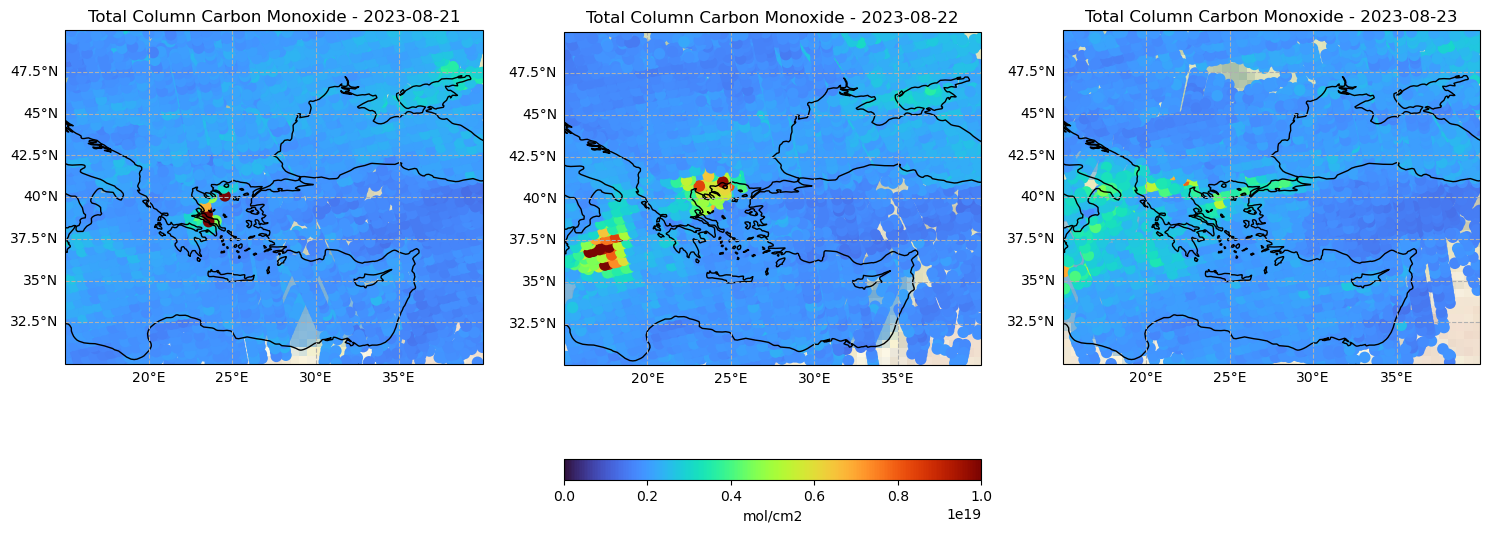

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i in range(len(co_gome2b.time)):
    ax = axes[i]
    # Plotting on the current axis
    hcooh_scatter = ax.scatter(co_gome2b[i].longitude, co_gome2b[i].latitude, c=co_gome2b[i].values,
                         transform=ccrs.PlateCarree(),
                         cmap='turbo', 
                         vmin=0, 
                         vmax=1e19, 
                         s=70,  # point size
                         edgecolor='none')

    ax.set_title(f'Total Column Carbon Monoxide - {str(np.datetime_as_string(co_gome2b[i].time.values, unit="D"))}')
    # Set the extent of the plot
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
        # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':10}
    gl.ylabel_style={'size':10}

fig.colorbar(hcooh_scatter, ax=axes[1], orientation='horizontal', fraction=0.36, pad=0.05, label='mol/cm2')
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Visualize separated time of day

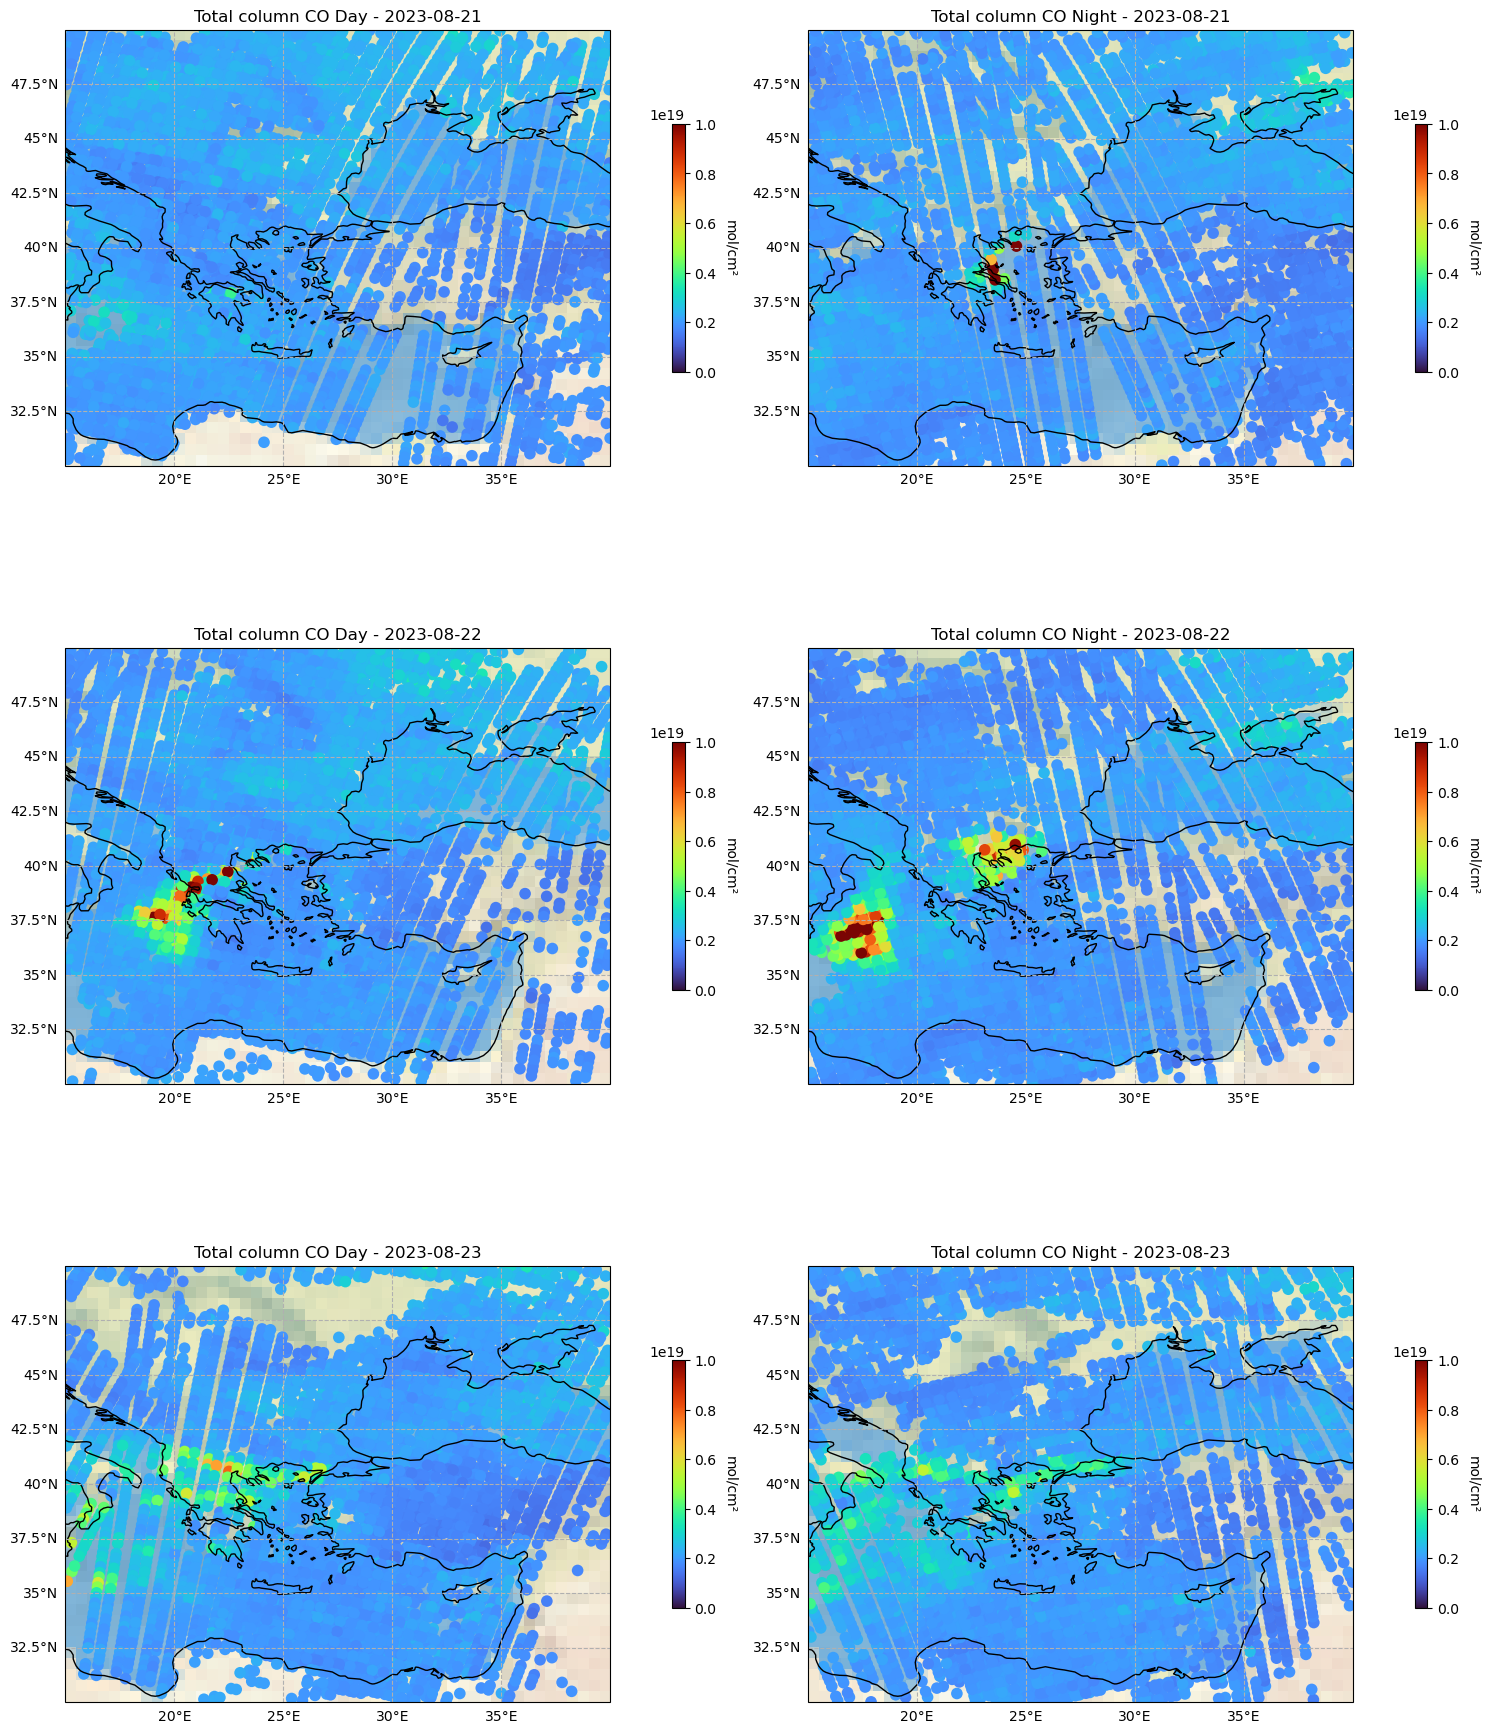

In [6]:
# Create the figure and axes for plotting
fig, axes = plt.subplots(3, 2, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten the array to iterate easily

def plot_data(ax, data, day_index, time_of_day):
    """
    Plot the data for a specific day index and time of day.
    """
    # Select the specific day
    selected_data = data.isel(time=day_index)
    
    # Extract relevant arrays
    lon = selected_data.longitude.values.flatten()
    lat = selected_data.latitude.values.flatten()
    values = selected_data.values.flatten()
    
    # Plotting
    scatter = ax.scatter(lon, lat, c=values, transform=ccrs.PlateCarree(),
                        cmap='turbo', 
                        vmin=0, 
                        vmax=1e19, 
                        s=70,  # point size
                        edgecolor='none')

    ax.set_title(f'Total column CO {time_of_day.capitalize()} - {str(np.datetime_as_string(selected_data.time.values, unit="D"))}')
    # Set the extent of the plot
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    return scatter

# Indices for the days
day_indices = [0, 1, 2]  # Indices for the three days

# Plot day data for each day
day_data = co_gome2b.sel(time_of_day='day')
for i in range(len(day_indices)):
    ax = axes[i*2]  # Even index for day data
    scatter = plot_data(ax, day_data, day_indices[i], 'day')

# Plot night data for each day
night_data = co_gome2b.sel(time_of_day='night')
for i in range(len(day_indices)):
    ax = axes[i*2 + 1]  # Odd index for night data
    scatter = plot_data(ax, night_data, day_indices[i], 'night')

for ax in axes:
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('mol/cm²', rotation=270, labelpad=15)


# Adjust layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Animation

The animation is useful to see the dispersion of CO during the event. The animation is played as a HTML5 video.

In [22]:
def plot_data(ax, data, day_index, time_of_day):
    ax.clear()  # Clear the current plot before drawing a new one
    
    selected_data = data.isel(time=day_index)
    # Extract relevant arrays
    lon = selected_data.longitude.values.flatten()
    lat = selected_data.latitude.values.flatten()
    values = selected_data.values.flatten()
    
    img = ax.scatter(lon, lat, c=values, transform=ccrs.PlateCarree(),
                        cmap='turbo', 
                        vmin=0, 
                        vmax=1e19, 
                        s=70,  # point size
                        edgecolor='none')
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    ax.set_title(f'Total column CO {time_of_day.capitalize()} - {str(np.datetime_as_string(selected_data.time.values, unit="D"))}')
    
    return img
    
def draw(i):
    
    day_index = i // 2
    time_of_day = 'day' if i % 2 == 0 else 'night'
    
     # Plot the day (day) data
    if time_of_day == 'day':
        img = plot_data(ax, day_data, day_index, 'day')
    else:
        img = plot_data(ax, night_data, day_index, 'night')

    return img


def init():
    return fig

def animate(i):
    return draw(i)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

img = plot_data(ax, day_data, 0, 'day')

# Add colorbar to the figure
colorbar = plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

# Example datasets for day and night
day_data = co_gome2b.sel(time_of_day='day')  # Replace with your actual data
night_data = co_gome2b.sel(time_of_day='night')  # Replace with your actual data

# Number of days
day_indices = range(len(day_data.time))  # Example day indices

# Number of frames (2 per day, one for day and one for night)
frames = len(day_indices) * 2

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=frames, interval=1000, blit=False, init_func=init, repeat=True)
plt.close(fig)
HTML(ani.to_html5_video())


## Formic Acid - HCOOH

### <a id='load_hcooh'></a>Load and preprocess Metop-A/B IASI Level 2 HCOOH data

The same pre-processing steps are used for Formic Acid.

In [8]:
def preprocess_hcooh(ds):
    target_size = 191065

    # Decode and convert time_string to datetime format
    time_strings = [time_str.decode('utf-8') for time_str in ds.time_string.values]
    times = pd.to_datetime(time_strings, format='%Y%m%dT%H%M%SZ')

   

    def fill_and_align(da, target_size, dim='ground_pixel'):
        """
        Fill missing values and align the specified dimension to the target size.
        """
        current_size = da.sizes.get(dim, None)
        if current_size is not None:
            if current_size < target_size:
                # Pad with NaNs
                padding = target_size - current_size
                da = da.pad({dim: (0, padding)}, constant_values=np.nan)
            elif current_size > target_size:
                # Truncate
                da = da.isel({dim: slice(0, target_size)})
        else:
            # If dimension is missing, create a new dimension with NaNs
            da = da.expand_dims({dim: target_size})
            da = da.pad({dim: (0, target_size)}, constant_values=np.nan)
        
        return da

    def process_time_range(ds, mask, time_of_day):
        """
        Process data for a specific time range defined by the mask.
        """
        # Use boolean indexing to select data
        hcooh = ds.isel(time=mask)['formic_acid_total_column']
        hcooh_da = generate_xr_from_1d_vec(file=ds.isel(time=mask),
                                           lat_path='latitude', 
                                           lon_path='longitude',
                                           variable=hcooh, 
                                           parameter_name=hcooh.name, 
                                           longname=hcooh.long_name, 
                                           no_of_dims=1, 
                                           unit=hcooh.units)
    
        hcooh_converted = hcooh_da * hcooh.multiplication_factor_to_convert_molecules_percm2
        
        hcooh_da_aligned = fill_and_align(hcooh_converted, target_size)
        hcooh_masked_da_aligned = hcooh_da_aligned.expand_dims(time_of_day=[time_of_day])
    
        return hcooh_masked_da_aligned

     # Create boolean masks for day and night times
    mask_day = (times.time >= pd.to_datetime("00:00:00").time()) & (times.time < pd.to_datetime("12:00:00").time())
    mask_night = (times.time >= pd.to_datetime("12:00:01").time()) & (times.time < pd.to_datetime("23:59:59").time())
    
    day_data = process_time_range(ds, mask_day, 'day')
    night_data = process_time_range(ds, mask_night, 'night')

    combined_data = xr.concat([day_data, night_data], dim='time_of_day')

    return combined_data

In [9]:
hcooh_gome2b = xr.open_mfdataset("data/metop/hcooh/*.nc", 
                                  concat_dim='time', 
                                  combine='nested',
                                  preprocess=preprocess_hcooh)

# Adjust time coordinates
start_day = '2023-08-21'  
time_coords = pd.date_range(pd.to_datetime(start_day), periods=len(hcooh_gome2b.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
hcooh_gome2b = hcooh_gome2b.assign_coords(time=time_coords)

hcooh_gome2b

<xarray.DataArray 'formic_acid_total_column' (time: 3, time_of_day: 2,
                                              ground_pixel: 191065)> Size: 5MB
dask.array<concatenate, shape=(3, 2, 191065), dtype=float32, chunksize=(1, 1, 80313), chunktype=numpy.ndarray>
Coordinates:
  * time_of_day  (time_of_day) object 16B 'day' 'night'
    latitude     (time, time_of_day, ground_pixel) float32 5MB 88.22 ... nan
    longitude    (time, time_of_day, ground_pixel) float32 5MB -89.93 ... nan
  * time         (time) datetime64[ns] 24B 2023-08-21 2023-08-22 2023-08-23
Dimensions without coordinates: ground_pixel

### <a id='visualize_hcooh'></a>Visualize Metop-A/B IASI Level 2 HCOOH data

#### Visualize both time of day

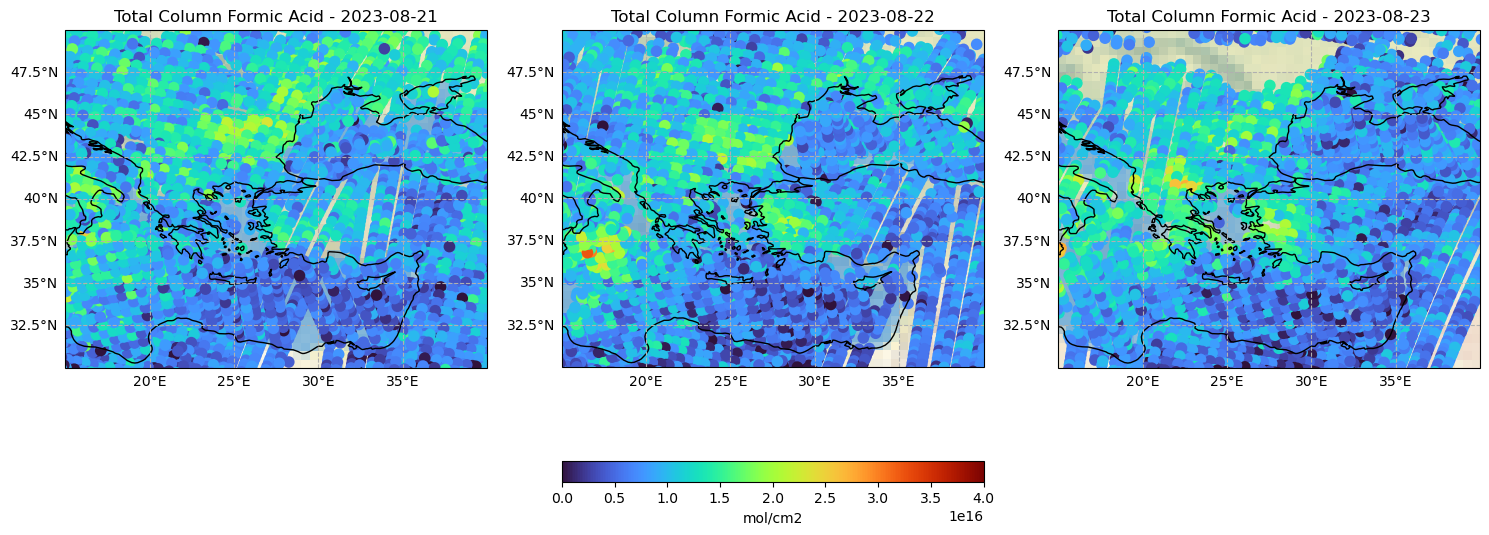

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i in range(len(hcooh_gome2b.time)):
    ax = axes[i]
    # Plotting on the current axis
    hcooh_scatter = ax.scatter(hcooh_gome2b[i].longitude, hcooh_gome2b[i].latitude, c=hcooh_gome2b[i].values,
                         transform=ccrs.PlateCarree(),
                         cmap='turbo', 
                         vmin=0, 
                         vmax=4e16, 
                         s=70,  # point size
                         edgecolor='none')

    ax.set_title(f'Total Column Formic Acid - {str(np.datetime_as_string(hcooh_gome2b[i].time.values, unit="D"))}')
    # Set the extent of the plot
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
        # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':10}
    gl.ylabel_style={'size':10}

fig.colorbar(hcooh_scatter, ax=axes[1], orientation='horizontal', fraction=0.36, pad=0.05, label='mol/cm2')
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Visualize separated time of day

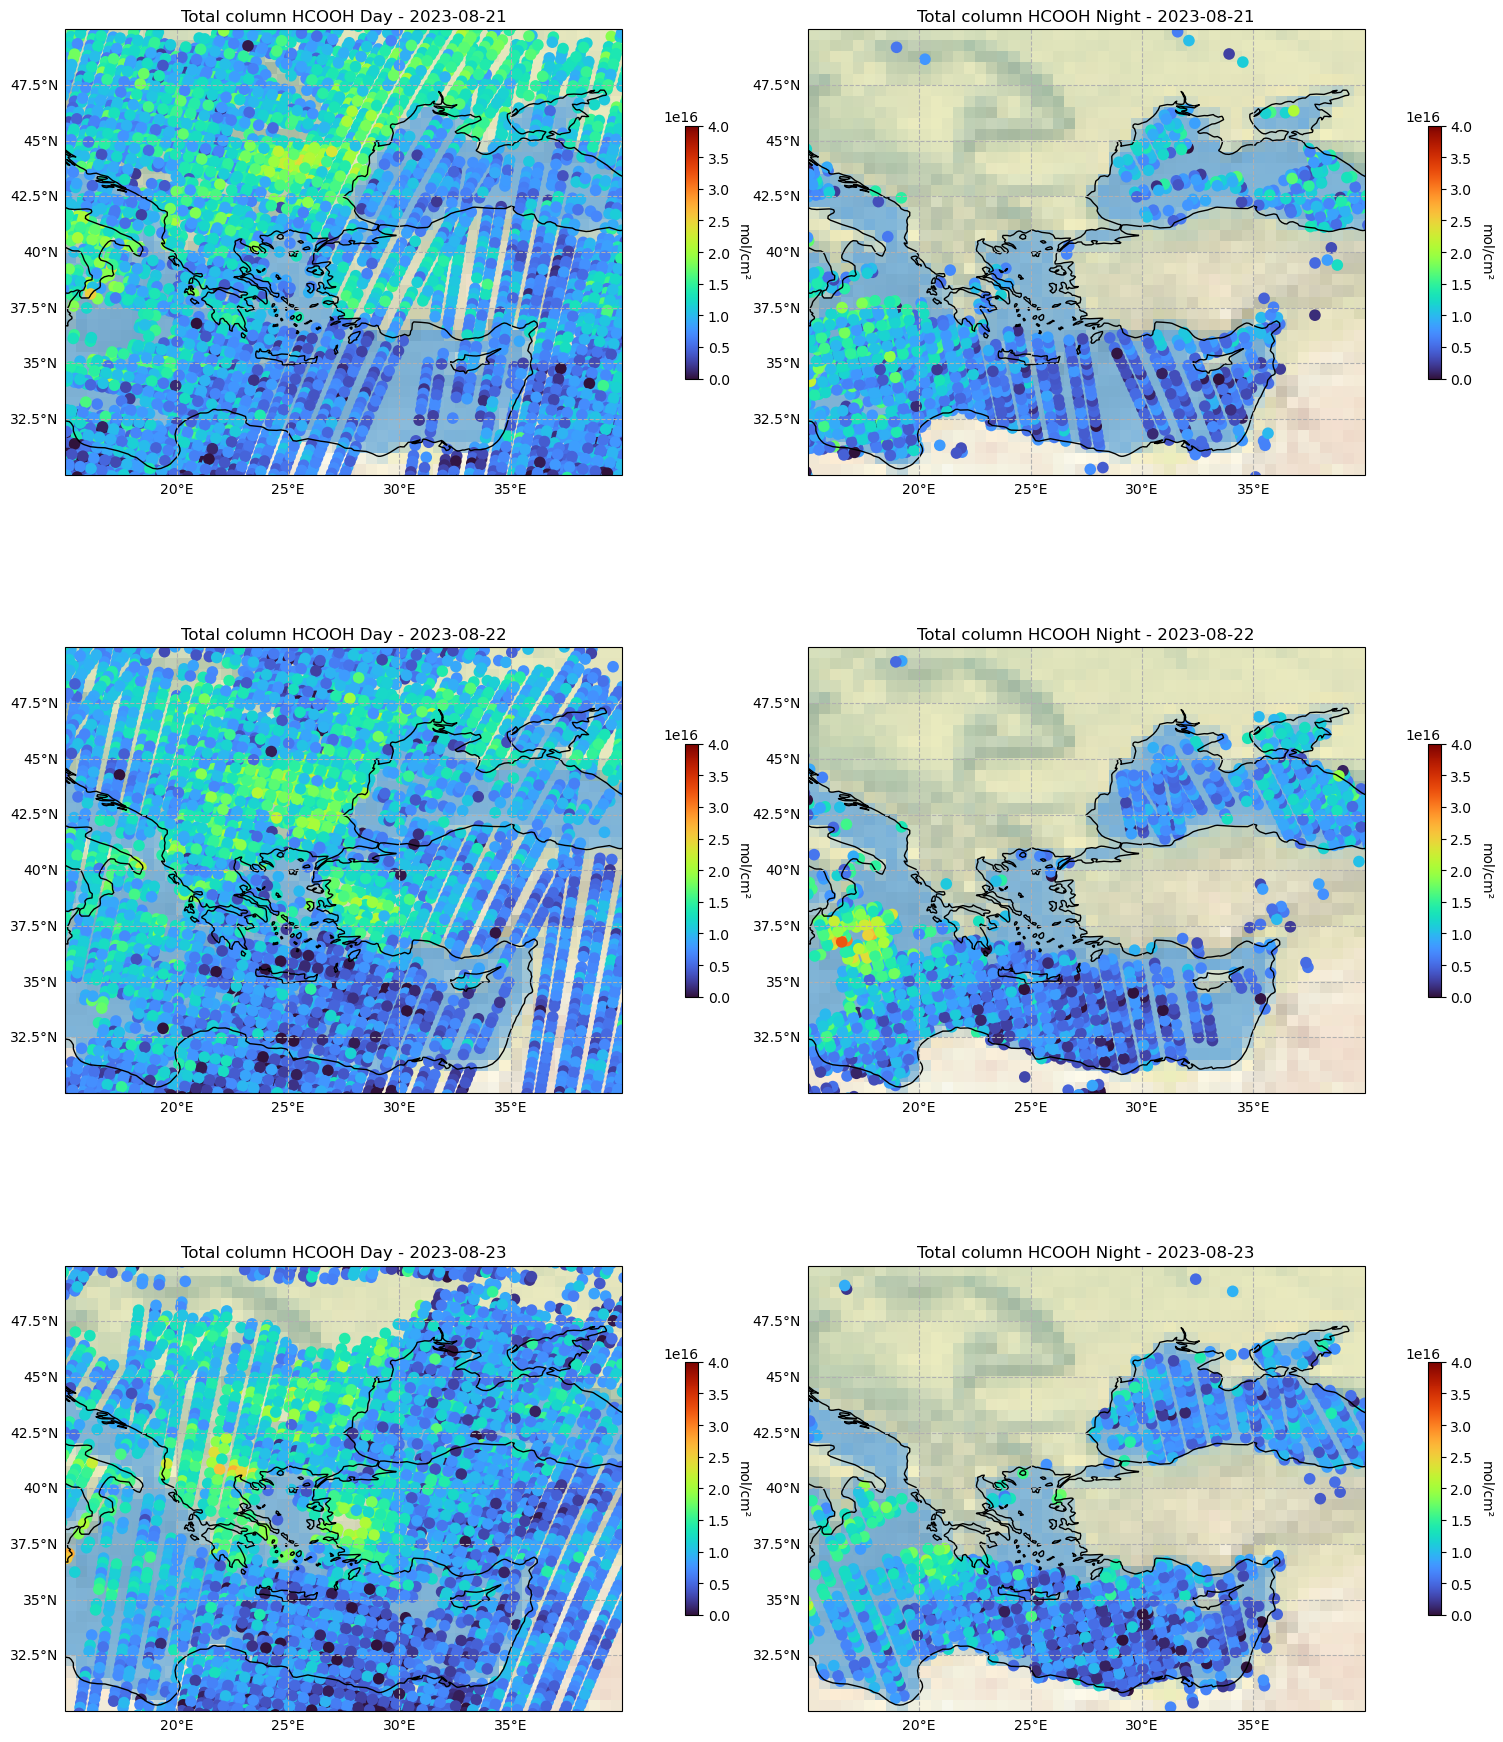

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten the array to iterate easily

def plot_data(ax, data, day_index, time_of_day):
    """
    Plot the data for a specific day index and time of day.
    """
    # Select the specific day
    selected_data = data.isel(time=day_index)
    
    # Extract relevant arrays
    lon = selected_data.longitude.values.flatten()
    lat = selected_data.latitude.values.flatten()
    values = selected_data.values.flatten()
    
    # Plotting
    scatter = ax.scatter(lon, lat, c=values, transform=ccrs.PlateCarree(),
                        cmap='turbo', 
                        vmin=0, 
                        vmax=4e16, 
                        s=70,  # point size
                        edgecolor='none')

    ax.set_title(f'Total column HCOOH {time_of_day.capitalize()} - {str(np.datetime_as_string(selected_data.time.values, unit="D"))}')
    # Set the extent of the plot
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    return scatter

# Indices for the days
day_indices = [0, 1, 2]  # Indices for the three days

# Plot day data for each day
day_data = hcooh_gome2b.sel(time_of_day='day')
for i in range(len(day_indices)):
    ax = axes[i*2]  # Even index for day data
    scatter = plot_data(ax, day_data, day_indices[i], 'day')

# Plot night data for each day
night_data = hcooh_gome2b.sel(time_of_day='night')
for i in range(len(day_indices)):
    ax = axes[i*2 + 1]  # Odd index for night data
    scatter = plot_data(ax, night_data, day_indices[i], 'night')

for ax in axes:
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('mol/cm²', rotation=270, labelpad=15)


# Adjust layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Animation

In [23]:
def plot_data(ax, data, day_index, time_of_day):
    ax.clear()  # Clear the current plot before drawing a new one
    
    selected_data = data.isel(time=day_index)
    # Extract relevant arrays
    lon = selected_data.longitude.values.flatten()
    lat = selected_data.latitude.values.flatten()
    values = selected_data.values.flatten()
    
    img = ax.scatter(lon, lat, c=values, transform=ccrs.PlateCarree(),
                        cmap='turbo', 
                        vmin=0, 
                        vmax=4e16, 
                        s=70,  # point size
                        edgecolor='none')
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    ax.set_title(f'Total column HCOOH {time_of_day.capitalize()} - {str(np.datetime_as_string(selected_data.time.values, unit="D"))}')
    
    return img
    
def draw(i):
    
    day_index = i // 2
    time_of_day = 'day' if i % 2 == 0 else 'night'
    
     # Plot the day (day) data
    if time_of_day == 'day':
        img = plot_data(ax, day_data, day_index, 'day')
    else:
        img = plot_data(ax, night_data, day_index, 'night')

    return img


def init():
    return fig

def animate(i):
    return draw(i)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

img = plot_data(ax, day_data, 0, 'day')

# Add colorbar to the figure
colorbar = plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

# Example datasets for day and night
day_data = hcooh_gome2b.sel(time_of_day='day')  # Replace with your actual data
night_data = hcooh_gome2b.sel(time_of_day='night')  # Replace with your actual data

# Number of days
day_indices = range(len(day_data.time))  # Example day indices

# Number of frames (2 per day, one for day and one for night)
frames = len(day_indices) * 2

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=frames, interval=1000, blit=False, init_func=init, repeat=True)
plt.close(fig)
HTML(ani.to_html5_video())


<hr>

### <a id='aai'></a>Load and Visualize Metop-A/B GOME-2 B Level 3 Absorbing Areosol Index (AAI) data

Absorbing Aerosol Index (AAI) Level 3 data product from the GOME-2 instrument onboard the three Metop satellites Metop-A/B/C. 

The Absorbing Aerosol Index (AAI) indicates the presence of elevated absorbing aerosols in the Earth’s atmosphere. The aerosol types that are mostly seen in the AAI are desert dust and biomass burning aerosols and is derived from reflectances measured by GOME-2 at 340 and 380 nm.

#### Load data

This code loads and processes aerosol index (AAI) data from multiple NetCDF files:

1. Load  multiple NetCDF files from the source directory, combining them along a new time dimension.
2. Extract the `absorbing_aerosol_index` variable
3. A sequence of daily time coordinates starting from '2023-08-21' is created and assigned to the dataset's time dimension.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).

In [13]:
aai_gome2 = xr.open_mfdataset('data/metop/aai_temis/*.nc', 
                         concat_dim='time', 
                         combine='nested')

aai_gome2=aai_gome2['absorbing_aerosol_index']

start_day = '2023-08-21'  
time_coords = pd.date_range(pd.to_datetime(start_day), periods=len(aai_gome2.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
aai_gome2 = aai_gome2.assign_coords(time=time_coords)
aai_gome2

<xarray.DataArray 'absorbing_aerosol_index' (time: 3, longitude: 360,
                                             latitude: 180)> Size: 778kB
dask.array<concatenate, shape=(3, 360, 180), dtype=float32, chunksize=(1, 360, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 24B 2023-08-21 2023-08-22 2023-08-23
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

#### Mask data to keep only values > 1

The code iterates through each time slice in the `aai_gome2` dataset, replacing values less than or equal to 1 with `np.nan`. This process filters out low AAI values, marking them as missing data.

In [14]:
for i in range(aai_gome2.shape[0]):  # Iterate over the time dimension
    # Create the mask for the ith time slice
    mask = aai_gome2[i] <= 1
    # Replace values less than or equal to 1 with np.nan using the mask
    aai_gome2[i] = np.where(mask, np.nan, aai_gome2[i])

#### Visualize

The next step is to visualize the Absorbing Aerosol Index data for each day.

You can use `magma_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, you can add the valid time step to the title of the plot.

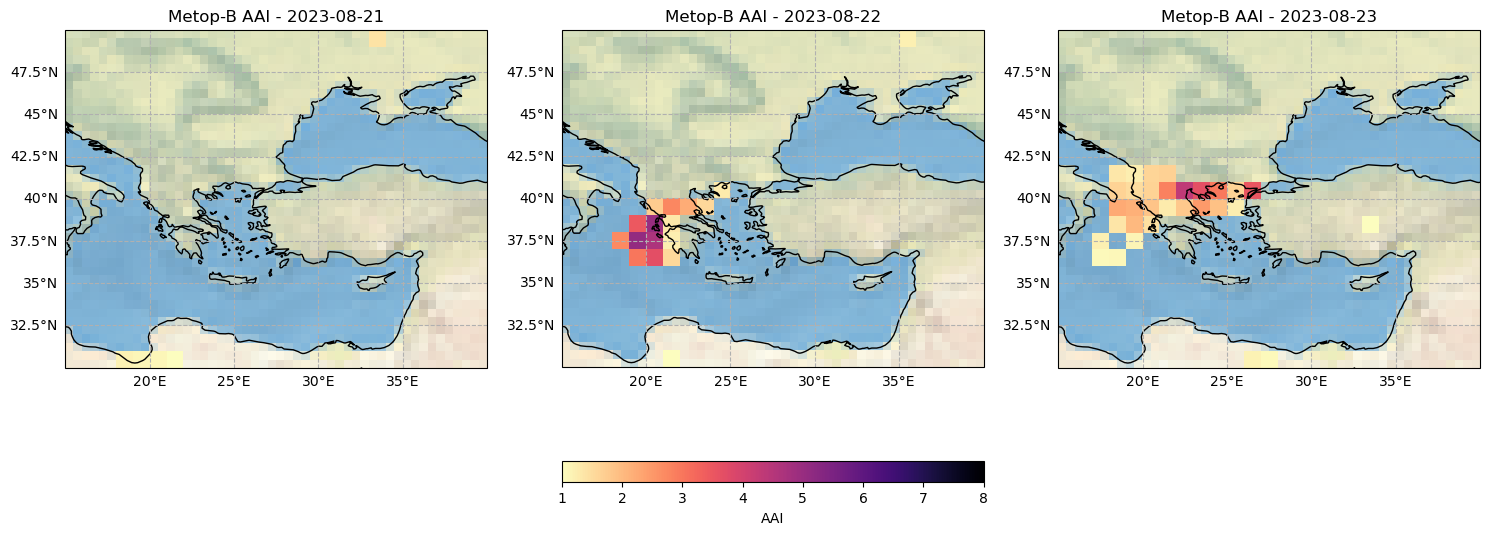

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i in range(len(aai_gome2.time)):
    ax = axes[i]
    # Plotting on the current axis
    mesh = ax.pcolormesh(aai_gome2.longitude, aai_gome2.latitude, aai_gome2[i, :, :].T,
                         transform=ccrs.PlateCarree(),
                         cmap='magma_r', 
                         vmin=1, 
                         vmax=8)
    
    # Set the extent of the plot
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    
    # Add a title
    ax.set_title('Metop-B AAI - ' + str(aai_gome2.time[i].dt.strftime('%Y-%m-%d').data)[0:10])
    
    # Add coastlines and gridlines
    ax.coastlines()
    ax.stock_img()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':10}
    gl.ylabel_style={'size':10}

fig.colorbar(mesh, ax=axes[1], orientation='horizontal', fraction=0.36, pad=0.05, label='AAI')
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<hr>

### Other resources

Some code in this notebook was adapted from the following sources: 
* https://fire.trainhub.eumetsat.int/docs/figure3_Metop-B_IASI_L2_CO.html
* https://dustbook.ltpy.adamplatform.eu/docs/gome2_aai.html